## Chapter 9. 비지도 학습

In [148]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 9.1 Cluster

In [149]:
# 예제 데이터 생성
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [150]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

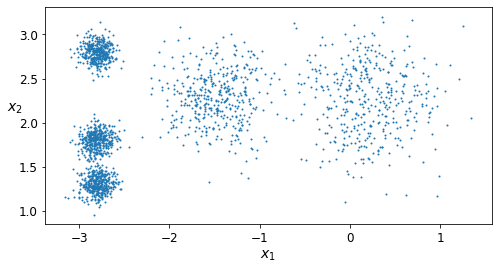

In [151]:

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [152]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=2022)
y_pred = kmeans.fit_predict(X)
y_pred

array([2, 4, 0, ..., 1, 0, 4])

In [153]:
y_pred is kmeans.labels_

True

In [154]:
# centroid
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

In [155]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 1, 1])

#### Plot k-Means Decision boundary

In [156]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

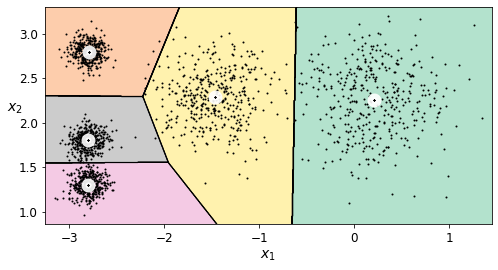

In [157]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [158]:
# 하드 군집 vs 소프트 군집
# 하드 군집은 각 샘플에 대해 가장 가까운 클러스터를 선택하는데, 이 대신 샘플에서 5개 센트로이드까지 거리를 측정하는 것이 나을 수 있음
# transform() 메서드에서 이 거리를 계산
kmeans.transform(X_new)

array([[0.32995317, 2.9042344 , 2.88633901, 1.49439034, 2.81093633],
       [2.80290755, 5.84739223, 5.84236351, 4.4759332 , 5.80730058],
       [3.29399768, 0.29040966, 1.71086031, 1.69136631, 1.21475352],
       [3.21806371, 0.36159148, 1.21567622, 1.54808703, 0.72581411]])

In [159]:
# 위 거리가 샘플과 센트로이드 사이의 유클리드 거리인지 확인
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.32995317, 2.9042344 , 2.88633901, 1.49439034, 2.81093633],
       [2.80290755, 5.84739223, 5.84236351, 4.4759332 , 5.80730058],
       [3.29399768, 0.29040966, 1.71086031, 1.69136631, 1.21475352],
       [3.21806371, 0.36159148, 1.21567622, 1.54808703, 0.72581411]])

#### $k$-평균 알고리즘
$k$-평균 알고리즘은 가장 빠르고 가장 간단한 군집 알고리즘 중 하나임  
- 먼저 $k$개의 센트로이드를 랜덤하게 초기화: 데이터셋에서 $k$개의 샘플을 랜덤하게 선택하고 센트로이드를 그 위치에 놓음  
- 수렴할 때까지 다음을 반복 (즉, 센트로이드가 더이상 이동하지 않을 때까지)  
    - 각 샘플을 가장 가까운 센트로이드에 할당
    - 센트로이드에 할당된 샘플의 평균으로 센트로이드를 업데이트   

`KMeans` 클래스는 기본적으로 최적화된 알고리즘을 적용함. 원래 $k$-평균 알고리즘을 사용하려면 `init="random"`, `n_init=1`, `algorithm="full"`로 설정해야 됨

In [160]:
# kMeans 알고리즘을 1, 2, 3회 반복하고 센트로이드가 어떻게 움직이는지 확인
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

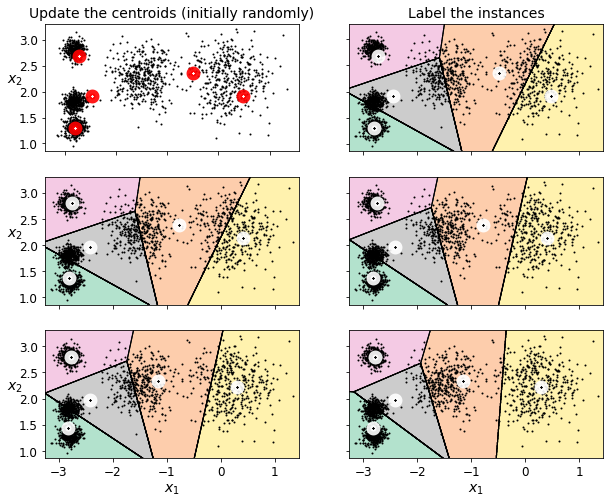

In [161]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

#### $k$-평균의 변동성
원래 $k$-평균 알고리즘에서는 센트로이드가 그냥 랜덤하게 초기화되고 알고리즘은 단순히 한번씩 반복하여 앞서 본 것처럼 점차 센트로이드를 개선시킴  
하지만, 이 방식의 문제점은 $k$-평균을 여러 번 (또는 다른 랜덤 시드로) 실행하면 아래에서 보듯 매우 다른 결과를 얻는다는 것

In [162]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

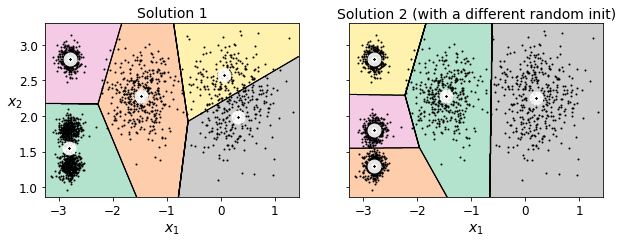

In [163]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

#### 이너셔
비지도 학습이기 때문에 타깃이 없지만, 적어도 각 샘플과 센트로이드 사이의 거리는 측정할 수 있음

In [164]:
# KMeans 이너셔 확인
kmeans.inertia_

211.59853725816836

In [165]:
# 이너셔는 각 훈련 샘플과 가장 가까운 센트로이드 사이의 제곱 거리의 합으로 쉽게 검증 가능
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.5985372581685

In [166]:
# 좋은 결과물일수록 높은 수가 되어야 하므로, 음수값으로 처리됨
kmeans.score(X)

-211.59853725816836

#### 다중 초기화
변동성 이슈를 해결하는 한 방법은 단순히 $k$-평균 알고리즘을 랜덤하게 초기화를 다르게 하여 여러 번 실행하고 가장 작은 이너셔를 만드는 솔루션을 선택하는 것  
예를 들어, 앞선 그림에 있는 엉터리 모델의 두 이너셔는 다음과 같음

In [167]:
kmeans_rnd_init1.inertia_, kmeans_rnd_init2.inertia_

(219.43539442771404, 211.59853725816836)

In [168]:
# 훈련된 좋은 모델보다 이너셔가 더 높음 = 더 나쁜 결과
# n_init 매개변수를 지정하면 사이킷런은 원래 알고리즘을 n_init번 실행하고 이너셔가 가장 작은 솔루션을 선택함
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

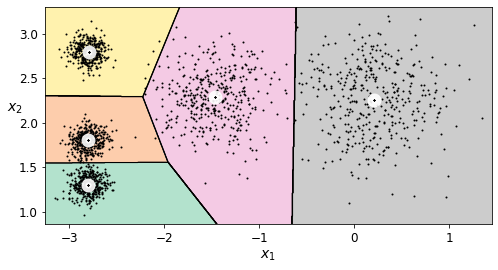

In [169]:
# 처음 만들었던 모델을 다시 얻음 = 최적의 k-Means 결과 (k=5라고 가정하고 이너셔를 기준으로 했을 때)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

#### 센트로이드 초기화 방법

In [170]:
# 센트로이드 초기화 방법
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1)

#### $k$-평균 속도 개선

In [171]:
# k-평균 속도 개선과 미니배치 k-평균
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

#### 최적의 클러스터 개수 찾기

In [172]:
# 최적의 클러스터 개수 정하기
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [173]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
                
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

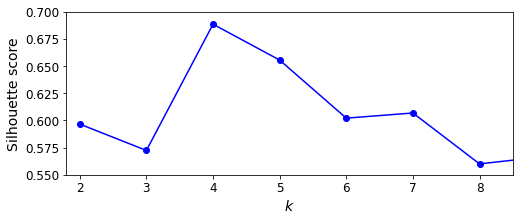

In [174]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

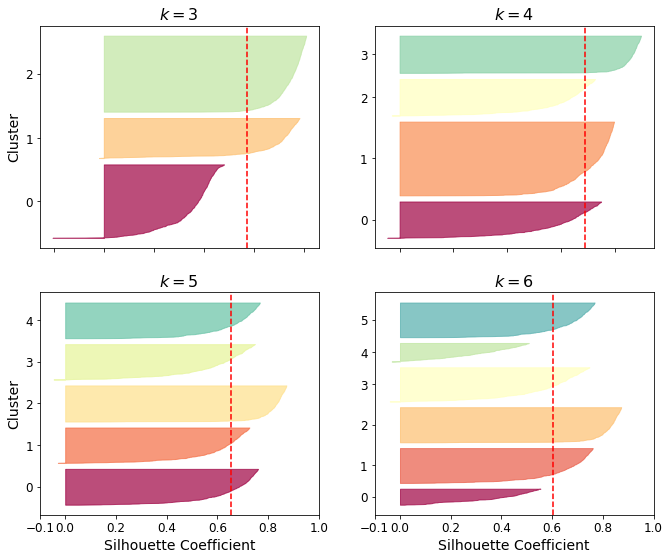

In [175]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

#### 군집을 사용한 이미지 분할

In [176]:
# 무당벌레 이미지를 다운로드
import urllib.request
import os

PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x215b2047e20>)

In [177]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [178]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [179]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

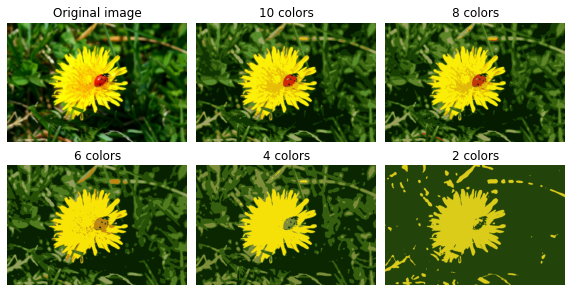

In [180]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
plt.show()

#### 군집을 사용한 전처리

In [181]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [182]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [183]:
from sklearn.linear_model import LogisticRegression
import warnings; warnings.filterwarnings('ignore')

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

log_reg.score(X_test, y_test)

0.9733333333333334

In [184]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50)),
    ('log_reg', LogisticRegression())
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg', LogisticRegression())])

In [185]:
pipeline.score(X_test, y_test)

0.9577777777777777

In [186]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg', LogisticRegression())]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [187]:
grid_clf.best_params_

{'kmeans__n_clusters': 68}

In [188]:
grid_clf.score(X_test, y_test)

0.9644444444444444

#### 군집을 사용한 준지도 학습

In [189]:
n_labeled = 50
log_reg = LogisticRegression(random_state=2023)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(random_state=2023)

In [190]:
log_reg.score(X_test, y_test)

0.8266666666666667

In [191]:
k = 50
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

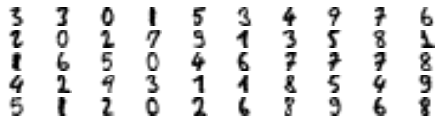

In [192]:
# 대표 이미지를 출력하고 수동으로 레이블을 매김
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show()

In [193]:
y_train[representative_digit_idx]

array([3, 3, 0, 1, 5, 3, 4, 9, 7, 6, 2, 0, 2, 7, 9, 1, 3, 5, 8, 1, 1, 6,
       5, 0, 4, 6, 7, 7, 7, 8, 4, 2, 9, 3, 1, 1, 8, 5, 4, 9, 5, 1, 2, 0,
       2, 6, 8, 9, 6, 8])

In [194]:
y_representative_digits = np.array([
    8, 9, 4, 6, 5, 7, 0, 2, 7, 3,
    2, 5, 5, 1, 6, 5, 1, 3, 1, 7,
    8, 4, 5, 5, 7, 8, 4, 4, 3, 7,
    6, 9, 4, 0, 2, 2, 8, 9, 8, 4,
    6, 3, 2, 1, 0, 8, 8, 9, 7, 6])

In [195]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=2023)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.14

In [196]:
# 레이블 전파
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [197]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=2023)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.1688888888888889

In [198]:
# 센트로이드 인근에만 레이블 전파
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [199]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=2023)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.1511111111111111

In [200]:
# 전파된 레이블과 실제 레이블의 유사도
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.14556331006979062

#### DBSCAN

In [201]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [202]:
dbscan.labels_

array([ 0,  1,  2,  1,  2,  0,  0,  2,  0, -1,  3,  0,  2,  3,  2,  0,  2,
        0,  2,  4,  2,  0,  3, -1,  0,  0,  2,  0,  4,  2, -1,  0, -1,  0,
        2,  2,  0,  0,  0,  3,  0,  0,  2,  3,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  3,  0,  1, -1,  3, -1,  0,  1,  0,  0, -1,  0,  0,  2,  3,
        3,  0,  0,  3,  0,  2,  3,  0,  0,  0,  1,  2,  0,  1,  3,  0,  2,
        4, -1,  0,  0,  2,  0,  2, -1, -1,  0,  0,  0,  0,  0,  0,  2,  3,
        4,  2,  1,  0,  0,  4,  2,  0,  4,  1,  1,  0,  3,  0,  4,  0,  0,
        0,  2,  0,  1,  3,  4,  0,  0,  0,  0,  2,  0,  3,  4,  3,  2,  3,
        0,  0,  2,  2,  0,  0,  2,  2,  0,  0,  0,  0,  0,  4,  0,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  3, -1,  2,  4,  0,  0,  0,  0,  2,  1,
        0,  2,  1,  0,  4,  2, -1,  4,  1,  0,  1,  0,  3,  2,  0,  0, -1,
       -1,  0,  3,  1,  2,  0,  1,  0,  3,  0, -1,  4,  0,  4,  4,  0,  3,
        0, -1,  0,  3,  0,  1,  2,  3,  0,  0,  0,  2,  0, -1,  1,  0,  2,
        4,  2,  0, -1,  0

In [203]:
# 핵심 샘플의 인덱스 수
len(dbscan.core_sample_indices_)

811

In [204]:
# 핵심 샘플의 인덱스
dbscan.core_sample_indices_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,
        15,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,
        31,  33,  34,  35,  36,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  52,  53,  54,  55,  57,  59,  60,  61,  64,
        65,  66,  67,  68,  69,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  81,  82,  83,  84,  85,  87,  88,  89,  90,  91,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 105, 106, 107, 108, 109, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 142, 143, 145, 147, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 170,
       171, 172, 173, 174, 175, 177, 178, 179, 180, 182, 184, 185, 188,
       189, 190, 191, 192, 193, 194, 196, 198, 200, 202, 204, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 218, 219, 22

In [205]:
# 핵심 샘플
dbscan.components_

array([[ 1.6913206 , -0.14991498],
       [-0.95811725,  0.1241573 ],
       [-0.63718749,  0.76394297],
       ...,
       [ 0.90517395,  0.28279674],
       [-0.04693902,  0.40932866],
       [-0.79936914,  0.59365922]])

In [206]:
import numpy as np
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

In [207]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [208]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

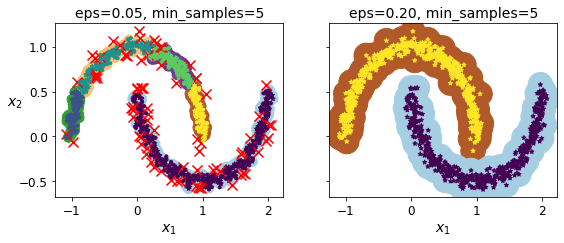

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [210]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [211]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 4, 0], dtype=int64)

In [212]:
knn.predict_proba(X_new)

array([[0.2 , 0.8 , 0.  , 0.  , 0.  ],
       [0.98, 0.  , 0.  , 0.02, 0.  ],
       [0.28, 0.  , 0.  , 0.  , 0.72],
       [1.  , 0.  , 0.  , 0.  , 0.  ]])

In [213]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  4, -1], dtype=int64)

#### 다른 군집 알고리즘

- 스펙트럼 군집

In [214]:
from sklearn.cluster import SpectralClustering
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=2023)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=2023)

In [215]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=2023)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=2023)

In [216]:
np.percentile(sc1.affinity_matrix_, 95)

0.04116055023554711

In [217]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

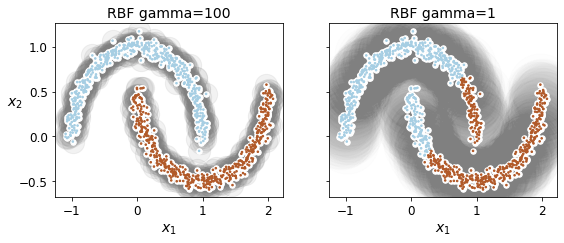

In [218]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

- 병합 군집

In [219]:
from sklearn.cluster import AgglomerativeClustering
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [220]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [221]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [222]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

### 9.2 Gaussian Mixture Model

In [223]:
from sklearn.datasets import make_blobs
import numpy as np

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [224]:
from sklearn.mixture import GaussianMixture
import warnings; warnings.filterwarnings('ignore')

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [225]:
gm.weights_

array([0.39019634, 0.2097235 , 0.40008016])

In [226]:
gm.means_

array([[ 0.05116693,  0.07505701],
       [ 3.39839223,  1.05935389],
       [-1.40763382,  1.42705028]])

In [227]:
gm.covariances_

array([[[ 0.68778225,  0.79591107],
        [ 0.79591107,  1.2122181 ]],

       [[ 1.14929846, -0.03260641],
        [-0.03260641,  0.95490238]],

       [[ 0.63478593,  0.7296996 ],
        [ 0.7296996 ,  1.1610729 ]]])

In [228]:
gm.converged_

True

In [229]:
gm.n_iter_

4

In [230]:
# 하드 군집
gm.predict(X)

array([0, 0, 2, ..., 1, 1, 1], dtype=int64)

In [231]:
# 소프트 군집
gm.predict_proba(X)

array([[9.76660045e-01, 2.33392754e-02, 6.79713861e-07],
       [9.82749546e-01, 1.65734903e-02, 6.76963988e-04],
       [7.42959049e-05, 2.04887015e-06, 9.99923655e-01],
       ...,
       [4.22276096e-07, 9.99999578e-01, 2.16925932e-26],
       [4.94998469e-16, 1.00000000e+00, 1.49550511e-41],
       [2.20699734e-15, 1.00000000e+00, 8.20533650e-41]])

In [232]:
X_new, y_new = gm.sample(6)

In [233]:
X_new

array([[-0.02680544,  0.0331156 ],
       [-0.31184459, -0.40081675],
       [-0.95550848,  1.75294555],
       [-2.17219169,  0.24320225],
       [-1.80713881,  2.2100752 ],
       [-0.24932544,  3.03487297]])

In [234]:
y_new

array([0, 0, 2, 2, 2, 2])

In [235]:
# 확률 밀도 함수의 로그 예측 = 모델의 밀도 추정
gm.score_samples(X)

array([-2.60767762, -3.57122831, -3.32967056, ..., -3.51338192,
       -4.39814914, -3.80773936])

#### 가우시안 혼합을 사용한 이상치 탐지

In [236]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]
anomalies

array([[-0.11118987,  1.61334992],
       [ 0.62362922,  4.41540435],
       [ 1.49808977, -0.15251688],
       [ 0.74219223, -1.00445177],
       [-2.53940854, -2.76549965],
       [-1.62447969, -0.45770022],
       [-1.74680316, -0.78385111],
       [-3.58308316, -1.28249917],
       [ 0.53903026,  5.00244257],
       [-0.51480414, -2.16270124],
       [-1.81015204, -0.58926015],
       [-1.79651788, -0.97031471],
       [-2.11225785, -2.09712817],
       [-3.39408574, -2.28378778],
       [ 1.58082729,  4.20122873],
       [-2.48037945, -1.18651064],
       [-2.93972237, -1.41660564],
       [-1.62285961, -2.84860478],
       [-0.25954463, -1.7743691 ],
       [ 0.46018217,  2.78323717],
       [-2.06317379,  2.2670332 ],
       [ 0.13982849,  2.08023553],
       [-2.54004484, -2.8290338 ],
       [-1.93037427, -1.19447352],
       [-0.27124433, -1.86750177],
       [-1.15568262, -2.57480367],
       [-1.93315582,  2.49030105],
       [ 4.93207567, -0.42157602],
       [ 5.80546094,

In [237]:
densities

array([-2.60767762, -3.57122831, -3.32967056, ..., -3.51338192,
       -4.39814914, -3.80773936])

In [238]:
density_threshold

-5.487784086563507

#### 클러스터 개수 선택하기

In [239]:
gm.bic(X)

8189.761570083466

In [240]:
gm.aic(X)

8102.536289968428

In [241]:
# AIC, BIC 수동 계산
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

bic, aic

(8189.761570083466, 8102.536289968428)

In [242]:
n_params

17

In [243]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [244]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

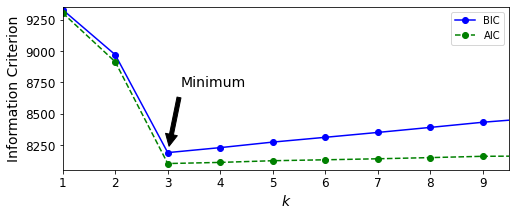

In [245]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

In [246]:
# 클러스터 개수와 covariance-type 하이퍼파라미터의 최적의 조합 탐색

min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [247]:
best_k

3

In [248]:
best_covariance_type

'full'

#### 베이즈 가우시안 혼합 모델

In [249]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=2023)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=2023)

In [250]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

#### 가능도 함수

In [251]:
from scipy.stats import norm
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

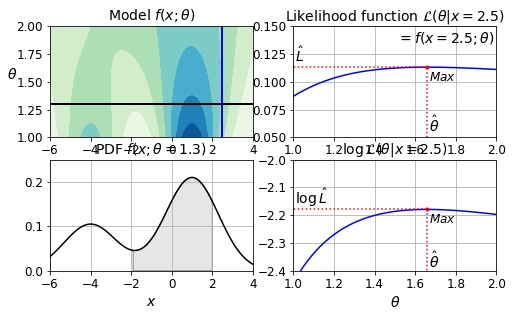

In [252]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.show()